#Data Preparation

In [1]:
import numpy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf


pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']

Mounted at /content/drive/


In [3]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 160

In [4]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

In [5]:
import random
test_player_list = random.sample(dict_player_name.keys(), 10)
test_player_list

[3707, 45954, 11568, 51581, 94797, 122909, 97027, 455, 41888, 6420]

In [6]:
test_player_list = [49180, 28867, 15509, 51581, 37046, 46854, 15485, 59481, 24473, 22689]

# MODEL&CONFIG

In [7]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq
def cal_rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [8]:
class MODEL_CONFIG:
  TEST_DATA_SIZE = 20
  INITIAL_WINDOW = 120
  WINDOW_LENTH = 20
  Filename = './Comparison_Work/Result.csv'
  Foldername = './Comparison_Work/Pic_Comparison/'
  def __init__(self, \
        LEARNING_RATE = 0.001,\
        TIME_STEP = 10,\
        DENSE = 1,\
        NUM_NODES = 30,\
        EPOCHS = 500,\
        STRUCTURE = 'RNN',\
        OPTIMIZER = 'SGD'):
    self.LEARNING_RATE = LEARNING_RATE
    self.TIME_STEP = TIME_STEP
    self.DENSE = DENSE
    self.NUM_NODES = NUM_NODES
    self.EPOCHS = EPOCHS
    self.STRUCTURE = STRUCTURE
    if OPTIMIZER == "SGD":
      self.OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    if OPTIMIZER == "ADAM":
      self.OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    if OPTIMIZER == "RMSprop":
      self.OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False)

In [9]:
def sliding_cv_fit(data, config, cur_player_id):
  list_mae = []
  list_mse = []
  list_r2 = []
  list_rmsle = []
  list_passtime = []
  #set model
  model = Sequential()
  if config.STRUCTURE == 'RNN':
    model.add(SimpleRNN(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  else:
    if config.STRUCTURE == 'GRU':
      model.add(GRU(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
    else:
      model.add(LSTM(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  model.add(Dense(config.DENSE))
  model.compile(loss='mean_squared_error', optimizer=config.OPTIMIZER)


  list_train_pred = []
  list_test_pred = []

  for train_mark in range(config.INITIAL_WINDOW, (len(data)//config.WINDOW_LENTH)*config.WINDOW_LENTH, config.WINDOW_LENTH):
    data_piece = data[train_mark - config.INITIAL_WINDOW : train_mark + config.WINDOW_LENTH]
    data_seq,result_seq = create_inout_sequences(data_piece, config.TIME_STEP)
    
    train_X = np.array(data_seq[:-config.TEST_DATA_SIZE])
    test_X = np.array(data_seq[-config.TEST_DATA_SIZE:])
    train_Y = np.array(result_seq[:-config.TEST_DATA_SIZE])
    test_Y = np.array(result_seq[-config.TEST_DATA_SIZE:])
    
    train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

    T1 = time.time()
    model.fit(train_X, train_Y, epochs=config.EPOCHS, batch_size=1, verbose=0)
    pass_time = time.time() - T1

    trainPredict = model(train_X)
    testPredict = model(test_X)
    if train_mark == config.INITIAL_WINDOW:
      list_train_pred = list_train_pred + list(trainPredict[:,0])
    else:
      list_train_pred = list_train_pred + list(trainPredict[:,0][-config.WINDOW_LENTH:])

    list_test_pred = list_test_pred + list(testPredict[:,0])

    list_mae.append(mean_absolute_error(test_Y, testPredict))
    list_mse.append(mean_squared_error(test_Y, testPredict))
    list_r2.append(r2_score(test_Y, testPredict))
    list_rmsle.append(cal_rmsle(test_Y, testPredict))
    list_passtime.append(pass_time)
  #create figure
  fig_len = len(data) // 10 + 2
  plt.figure(figsize=[fig_len,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(list_train_pred)
  len_testP = len(list_test_pred)
  plt.plot(range(config.TIME_STEP,config.TIME_STEP+len_trainP),list_train_pred,color='orange')
  plt.plot(range(config.INITIAL_WINDOW,config.INITIAL_WINDOW+len_testP),list_test_pred,color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.title('Performance of ' + dict_player_name[cur_player_id])

  plt.savefig(config.Foldername + str(cur_player_id) + '.jpg')
  print('\nSave fig to:' + config.Foldername + str(cur_player_id) + '.jpg')
  #plt.show()

  return np.mean(list_mae),np.mean(list_mse),np.mean(list_r2),np.mean(list_rmsle),np.mean(list_passtime)

#RNN

In [10]:
df_RNN_para = pd.read_csv('./Comparison_Work/RNN_ParaResultCV.csv')
df_RNN_para = df_RNN_para.sort_values(by="MSE",ascending=True)
print(df_RNN_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
9           0.001          6      1         40     400      ADAM          NaN   
21          0.001          7      1         40     400      ADAM          NaN   
3           0.001          6      1         20     500      ADAM          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
9   0.187822  0.065101  0.030805  0.514504  
21  0.205720  0.071732  0.033416  0.327540  
3   0.218230  0.072009  0.034048  0.234984  
23  0.206363  0.074220  0.032909  0.368549  
7   0.218965  0.074643  0.034163  0.258224  


In [11]:
config_RNN = MODEL_CONFIG(0.001,6,1,40,400,'RNN','ADAM')
config_RNN.Filename = './Comparison_Work/TrainSet120/RNN_Result.csv'
config_RNN.Foldername = './Comparison_Work/TrainSet120/Pic_RNN/'

 10%|█         | 1/10 [02:25<21:53, 145.90s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/49180.jpg

	TIME_PER_TRAIN(Second):72.47881174087524

	MAE:0.17037964057922356
	MSE:0.051451810874696746
	R2:0.8064005634967524
	RMSLE:0.025788477228516675


 20%|██        | 2/10 [05:34<22:46, 170.83s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/28867.jpg

	TIME_PER_TRAIN(Second):62.66229168574015

	MAE:0.21553134632110582
	MSE:0.07322095973928816
	R2:0.5093984835451129
	RMSLE:0.03559570621753266


 30%|███       | 3/10 [11:46<30:38, 262.64s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/15509.jpg

	TIME_PER_TRAIN(Second):74.30729322433471

	MAE:0.2047155254364014
	MSE:0.06404262143417895
	R2:-0.23112353539769986
	RMSLE:0.031330713275175635


 40%|████      | 4/10 [13:51<20:50, 208.36s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/51581.jpg

	TIME_PER_TRAIN(Second):62.42653000354767

	MAE:0.15892610454559328
	MSE:0.04594629704813301
	R2:0.6095836570467494
	RMSLE:0.027236502020387597


 50%|█████     | 5/10 [19:41<21:37, 259.53s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/37046.jpg

	TIME_PER_TRAIN(Second):69.98060398101806

	MAE:0.17722906303405767
	MSE:0.048758629225166036
	R2:0.4682992325664532
	RMSLE:0.02823702549421369


 60%|██████    | 6/10 [21:04<13:17, 199.44s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/46854.jpg

	TIME_PER_TRAIN(Second):82.54098796844482

	MAE:0.20645607852935802
	MSE:0.06532160282507611
	R2:0.2901291817442474
	RMSLE:0.03417337955689396


 70%|███████   | 7/10 [25:11<10:44, 214.92s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/15485.jpg

	TIME_PER_TRAIN(Second):82.15804409980774

	MAE:0.1489279680252075
	MSE:0.03829271206639842
	R2:0.330095383755694
	RMSLE:0.026637633703630214


 80%|████████  | 8/10 [28:36<07:03, 211.83s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/59481.jpg

	TIME_PER_TRAIN(Second):68.31431150436401

	MAE:0.22085859012603784
	MSE:0.07559273809144089
	R2:0.2512876154764274
	RMSLE:0.03504751787427904


 90%|█████████ | 9/10 [32:23<03:36, 216.54s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/24473.jpg

	TIME_PER_TRAIN(Second):75.53374656041463

	MAE:0.19560252285003665
	MSE:0.05769946874207688
	R2:0.5501841764279644
	RMSLE:0.03209255404406119


100%|██████████| 10/10 [35:27<00:00, 212.77s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_RNN/22689.jpg

	TIME_PER_TRAIN(Second):61.42261775334676

	MAE:0.2414229234059652
	MSE:0.08654354164449828
	R2:-0.7250486325002984
	RMSLE:0.036799659039592945


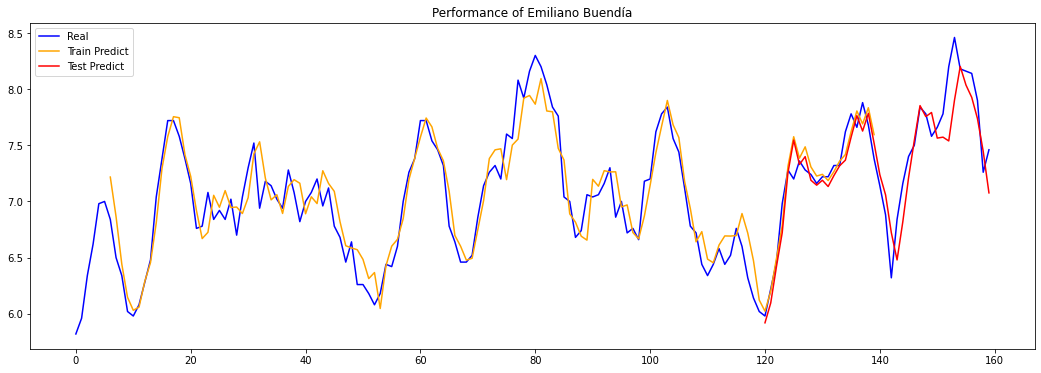

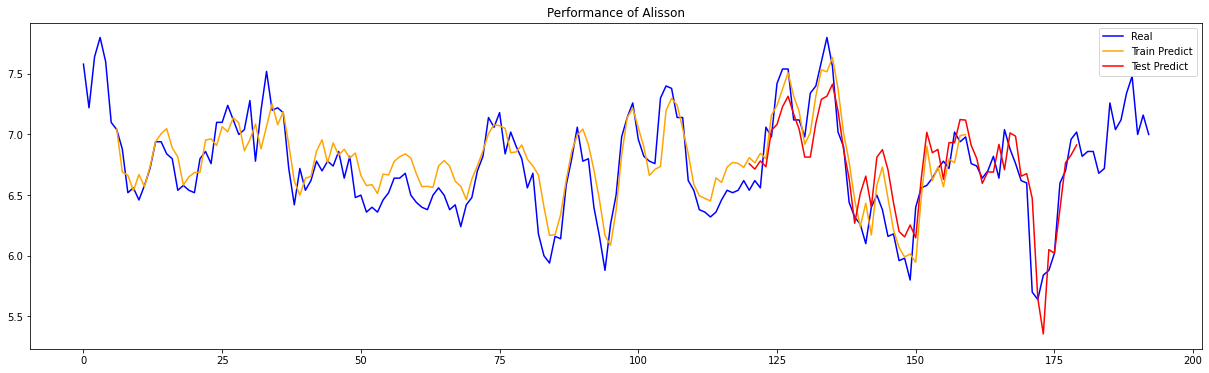

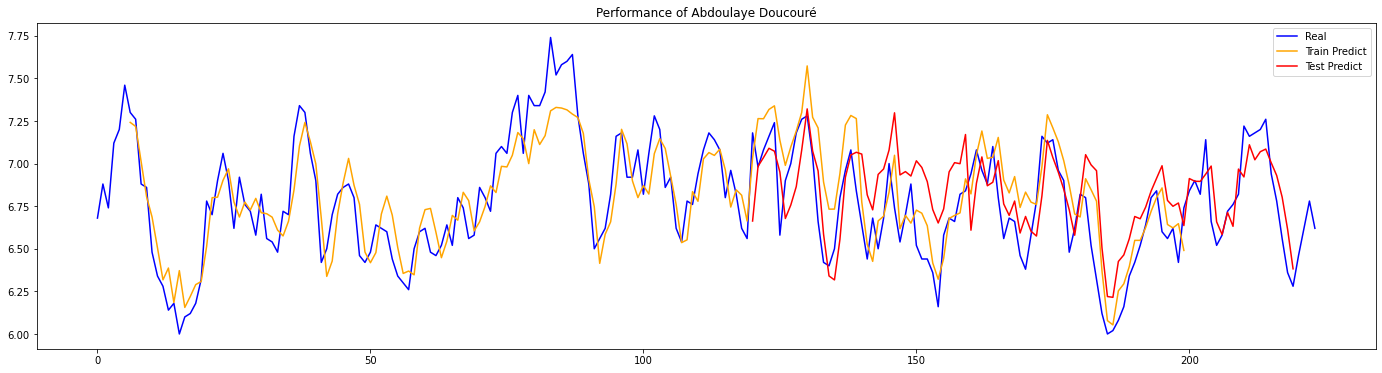

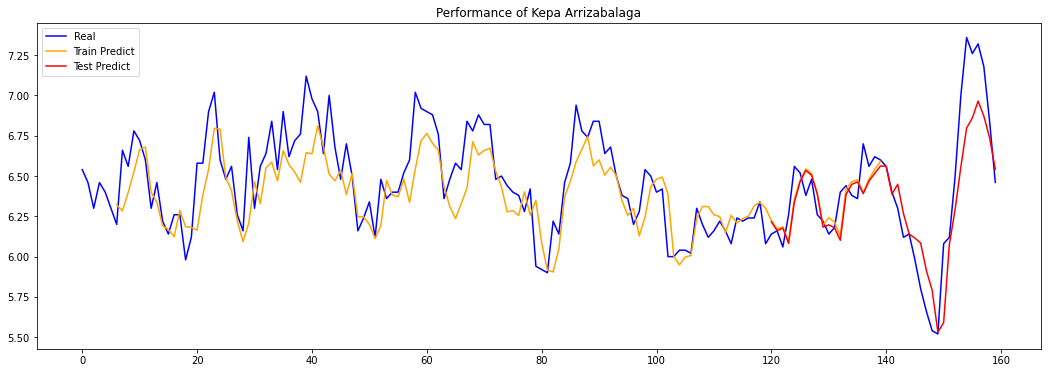

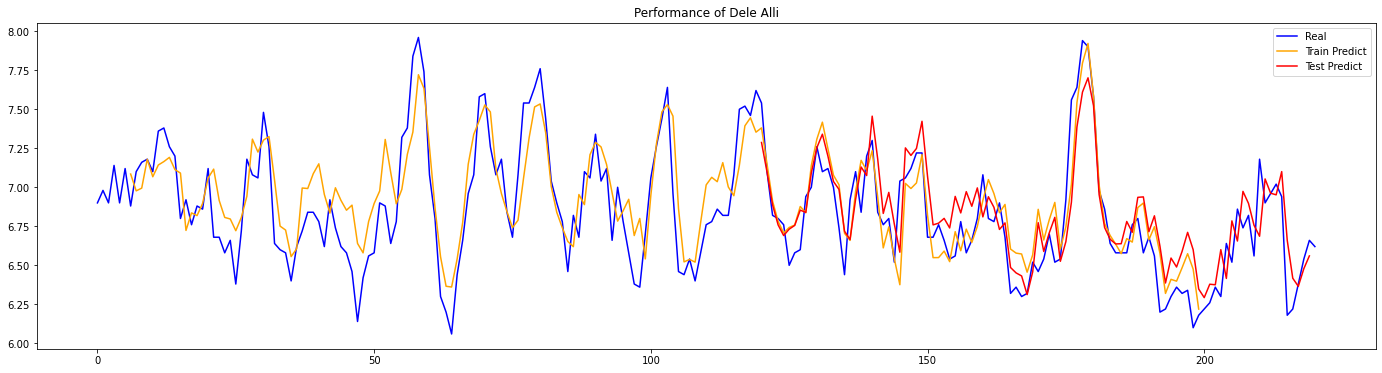

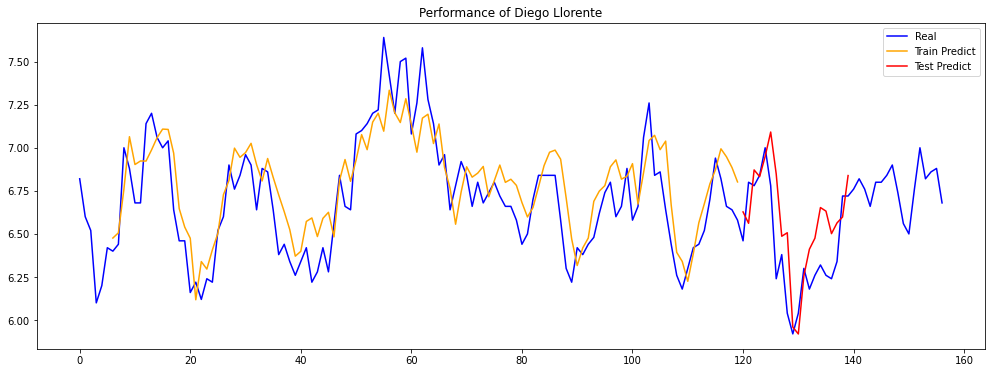

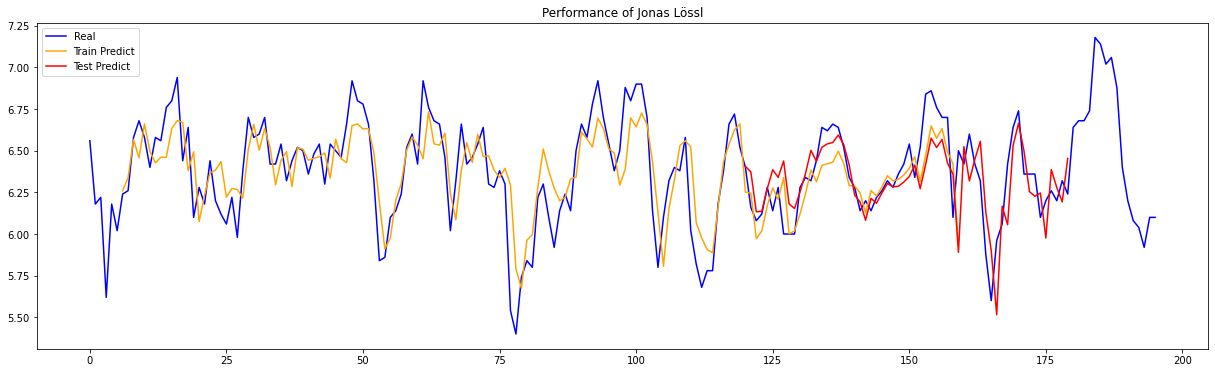

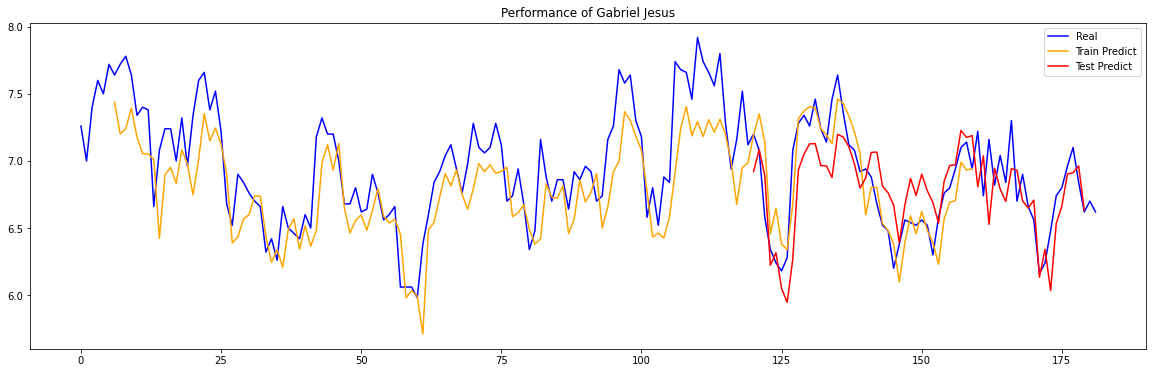

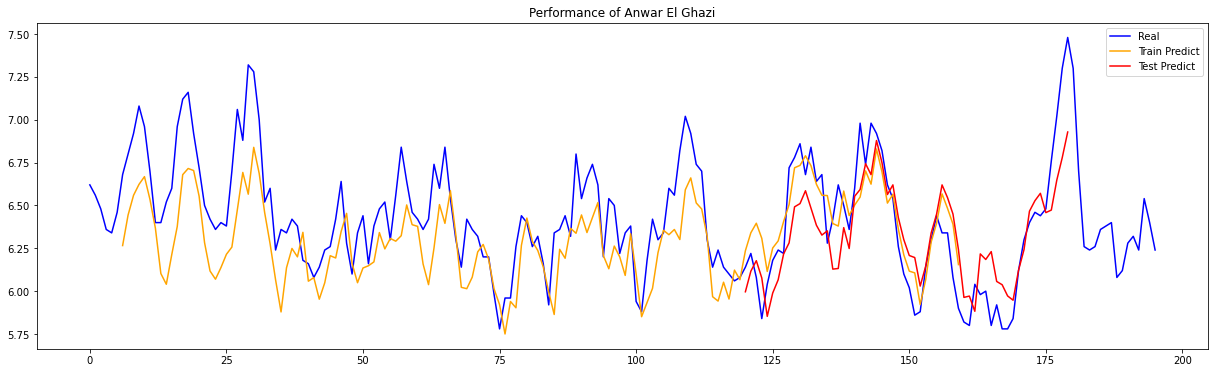

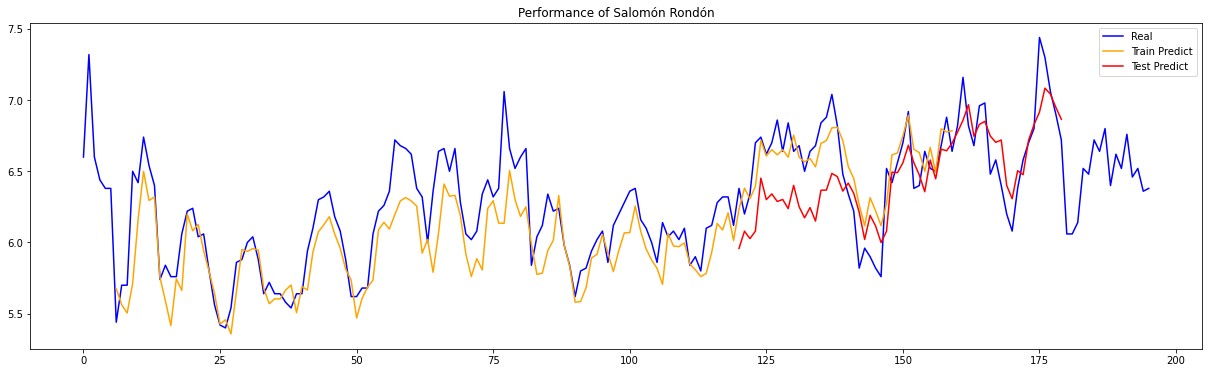

In [12]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_RNN, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_RNN.Filename,index=0)

#GRU

In [13]:
df_GRU_para = pd.read_csv('./Comparison_Work/GRU_ParaResultCV.csv')
df_GRU_para = df_GRU_para.sort_values(by="MSE",ascending=True)
print(df_GRU_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
11          0.001          6      1         40     500      ADAM          NaN   
28          0.001          8      1         30     400       SGD          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
9           0.001          6      1         40     400      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
11  0.187576  0.061778  0.030586  0.512846  
28  0.190322  0.062103  0.031119  0.454427  
23  0.196848  0.062525  0.031652  0.370999  
9   0.189588  0.062596  0.030822  0.501661  
7   0.193299  0.062757  0.031032  0.417338  


In [14]:
config_GRU = MODEL_CONFIG(0.001,6,1,40,500,'GRU','ADAM')
config_GRU.Filename = './Comparison_Work/TrainSet120/GRU_Result.csv'
config_GRU.Foldername = './Comparison_Work/TrainSet120/Pic_GRU/'

 10%|█         | 1/10 [03:00<27:03, 180.42s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/49180.jpg

	TIME_PER_TRAIN(Second):89.99569141864777

	MAE:0.18216780424118037
	MSE:0.0662791157169772
	R2:0.753763344865414
	RMSLE:0.028635274499842968


 20%|██        | 2/10 [09:16<39:23, 295.44s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/28867.jpg

	TIME_PER_TRAIN(Second):125.16716170310974

	MAE:0.18370395819346116
	MSE:0.057912645352487545
	R2:0.6332903772400125
	RMSLE:0.031742052705842246


 30%|███       | 3/10 [20:16<53:54, 462.00s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/15509.jpg

	TIME_PER_TRAIN(Second):131.93562874794006

	MAE:0.15758408126831053
	MSE:0.037968064416969934
	R2:0.3661307998763653
	RMSLE:0.025103558954720086


 40%|████      | 4/10 [24:09<37:10, 371.68s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/51581.jpg

	TIME_PER_TRAIN(Second):116.38971328735352

	MAE:0.15373040580749514
	MSE:0.04275432648337468
	R2:0.6355113208222463
	RMSLE:0.02635397644955542


 50%|█████     | 5/10 [33:24<36:27, 437.52s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/37046.jpg

	TIME_PER_TRAIN(Second):110.74583129882812

	MAE:0.17418681831359864
	MSE:0.05021703854348847
	R2:0.5013897130904397
	RMSLE:0.02869380075802521


 60%|██████    | 6/10 [35:47<22:30, 337.56s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/46854.jpg

	TIME_PER_TRAIN(Second):143.09708857536316

	MAE:0.16736351394653332
	MSE:0.0459589754059246
	R2:0.5005490669761181
	RMSLE:0.02869440144708221


 70%|███████   | 7/10 [41:10<16:38, 332.72s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/15485.jpg

	TIME_PER_TRAIN(Second):107.43321808179219

	MAE:0.14040511417388926
	MSE:0.03259748281034968
	R2:0.42519653407806296
	RMSLE:0.024799835189073593


 80%|████████  | 8/10 [47:25<11:32, 346.13s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/59481.jpg

	TIME_PER_TRAIN(Second):124.789084593455

	MAE:0.21220561726888007
	MSE:0.06786410465418458
	R2:0.21111846024285777
	RMSLE:0.0332169030809832


 90%|█████████ | 9/10 [51:53<05:21, 321.79s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/24473.jpg

	TIME_PER_TRAIN(Second):89.27325558662415

	MAE:0.16623953596750893
	MSE:0.047104767018576875
	R2:0.6509016569493803
	RMSLE:0.028746872454536877


100%|██████████| 10/10 [59:00<00:00, 354.09s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_GRU/22689.jpg

	TIME_PER_TRAIN(Second):142.3200458685557

	MAE:0.18740192159016936
	MSE:0.05476158497826808
	R2:0.2581625793775614
	RMSLE:0.030696132033891665


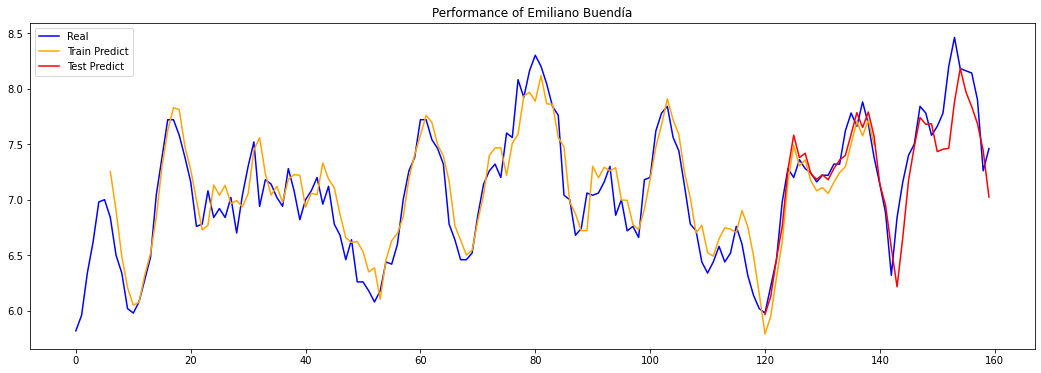

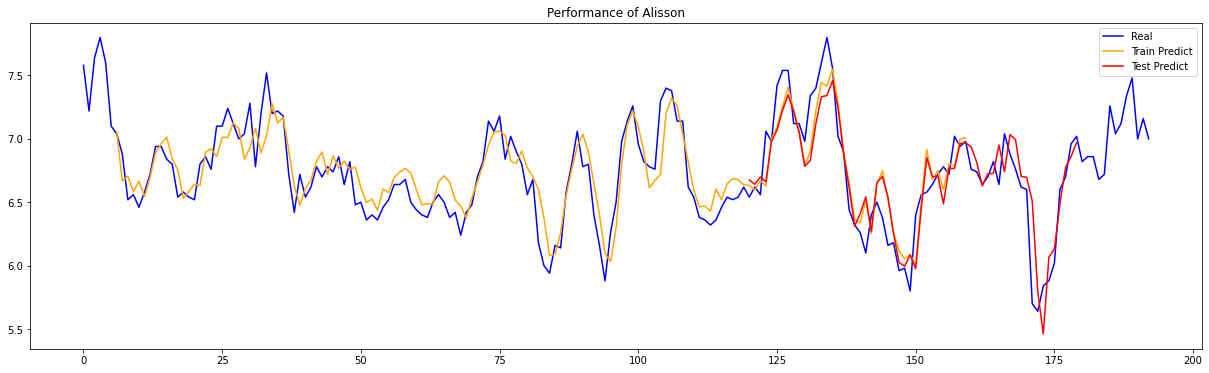

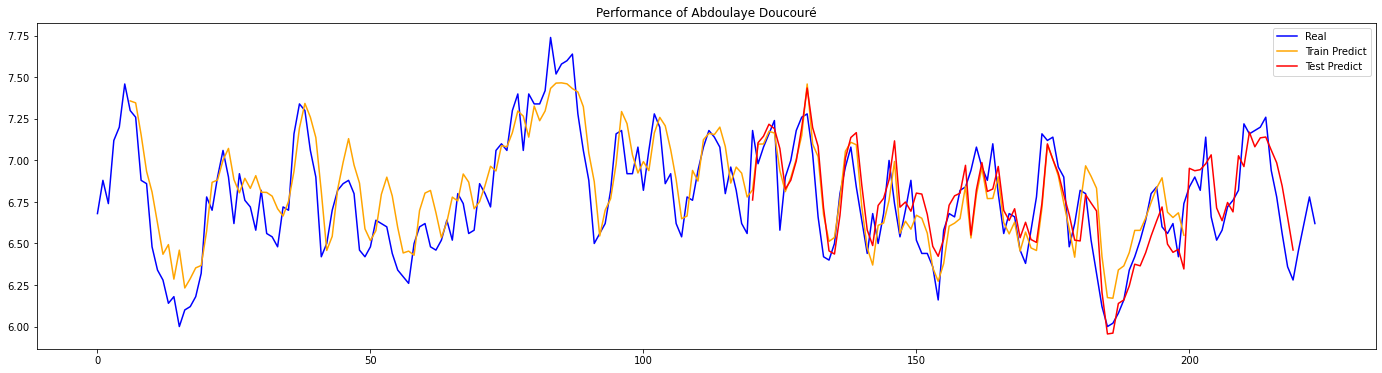

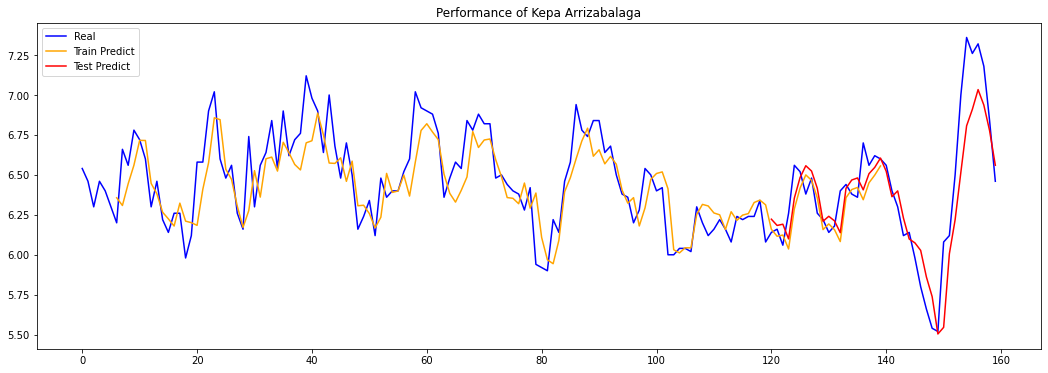

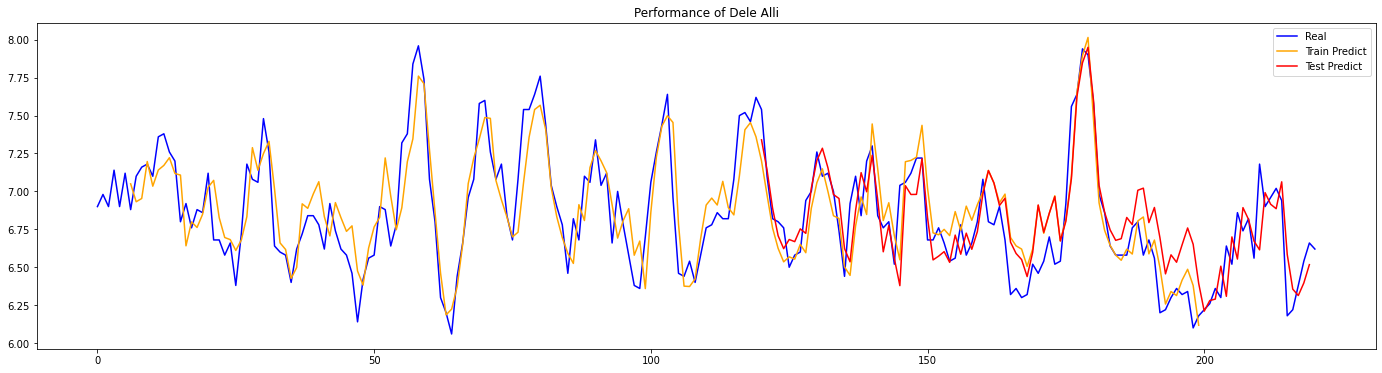

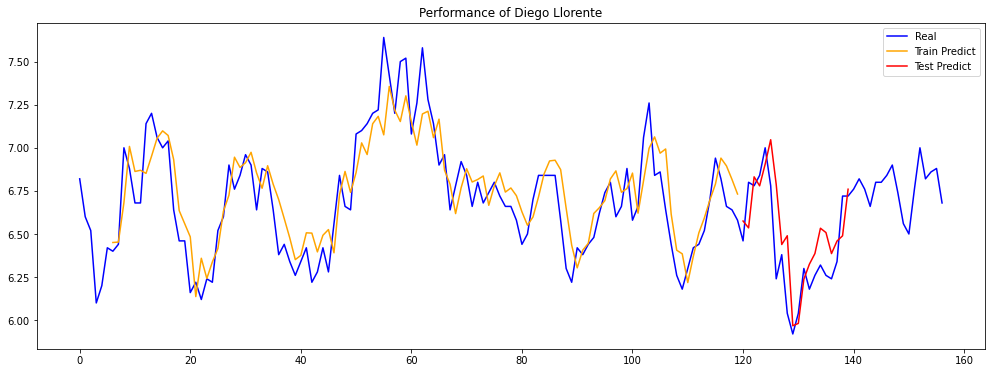

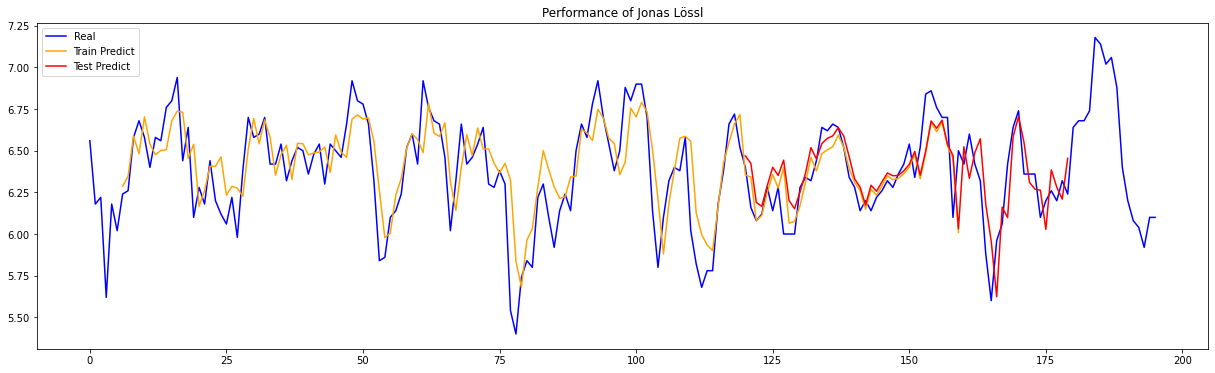

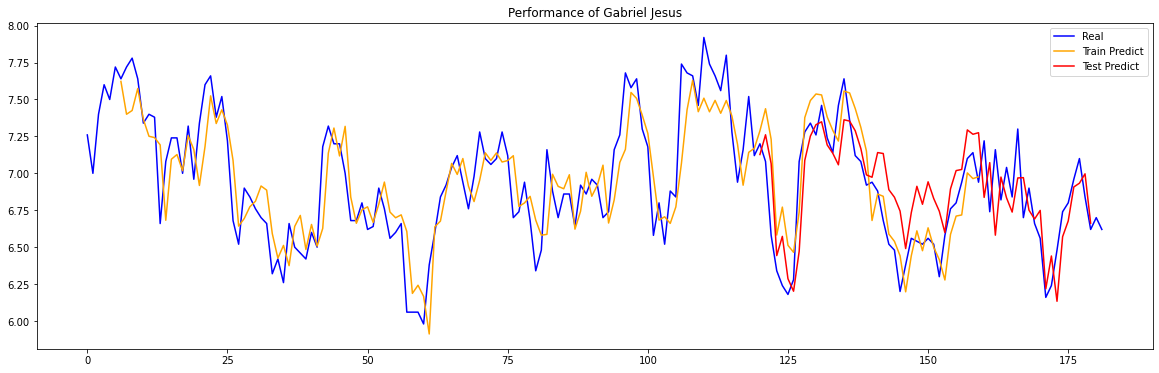

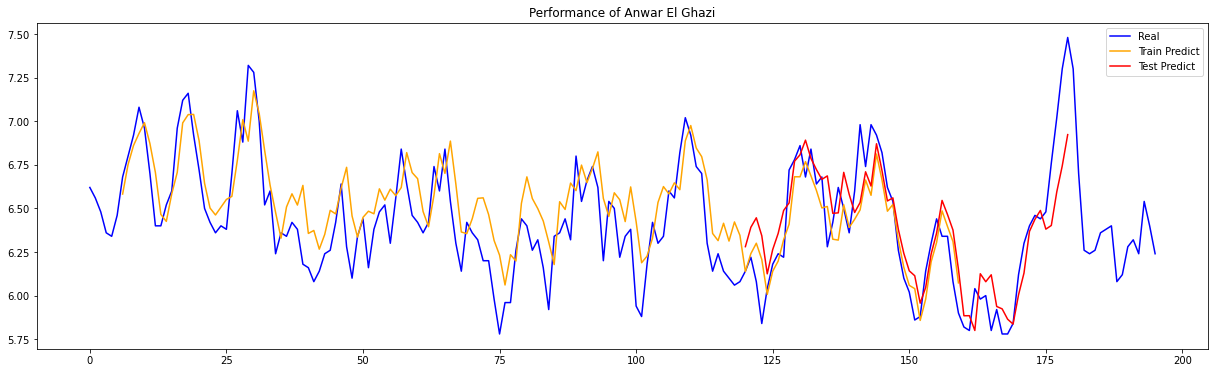

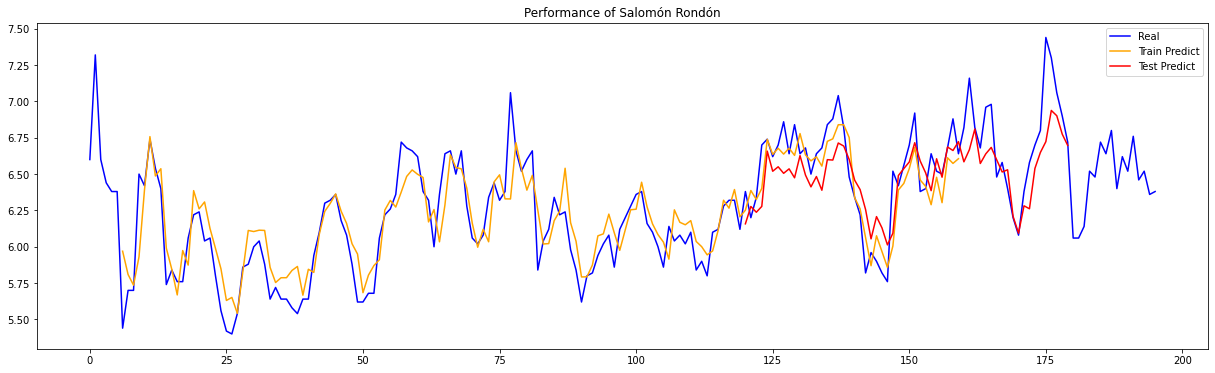

In [15]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_GRU, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_GRU.Filename,index=0)

#LSTM

In [16]:
df_para = pd.read_csv('ParaResultCV.csv')
df_para = df_para.sort_values(by="MSE",ascending=True)
print(df_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
23          0.001          7      1         20     500      ADAM          NaN   
34          0.001          7      1         40     500       SGD          NaN   
9           0.001          6      1         30     400      ADAM          NaN   
3           0.001          6      1         20     400      ADAM          NaN   
32          0.001          7      1         40     400       SGD          NaN   

         MAE       MSE     RMSLE        R2  
23  0.179809  0.055023  0.029342  0.516331  
34  0.185452  0.057287  0.030016  0.476154  
9   0.188581  0.059201  0.030295  0.502503  
3   0.189823  0.061629  0.030634  0.485452  
32  0.189335  0.062664  0.030677  0.485385  


In [17]:
config_LSTM = MODEL_CONFIG(0.001,7,1,20,500,'LSTM','ADAM')
config_LSTM.Filename = './Comparison_Work/TrainSet120/LSTM_Result.csv'
config_LSTM.Foldername = './Comparison_Work/TrainSet120/Pic_LSTM/'

 10%|█         | 1/10 [03:52<34:53, 232.63s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/49180.jpg

	TIME_PER_TRAIN(Second):116.07702493667603

	MAE:0.21501031541824328
	MSE:0.06816215971532616
	R2:0.7309775422334264
	RMSLE:0.03158567103194164


 20%|██        | 2/10 [09:14<38:02, 285.34s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/28867.jpg

	TIME_PER_TRAIN(Second):107.25403030713399

	MAE:0.20441963704427102
	MSE:0.07086691667970842
	R2:0.5585863959881449
	RMSLE:0.0347710102996125


 30%|███       | 3/10 [18:23<47:18, 405.44s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/15509.jpg

	TIME_PER_TRAIN(Second):109.56075415611267

	MAE:0.17961227149963377
	MSE:0.04980620587788384
	R2:0.23619523576087217
	RMSLE:0.028200622208437907


 40%|████      | 4/10 [21:21<31:33, 315.60s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/51581.jpg

	TIME_PER_TRAIN(Second):88.69714832305908

	MAE:0.1904738826751708
	MSE:0.048808901582076805
	R2:0.5332947359182868
	RMSLE:0.029151946108606393


 50%|█████     | 5/10 [30:29<33:18, 399.67s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/37046.jpg

	TIME_PER_TRAIN(Second):109.56589179039001

	MAE:0.16916676654815674
	MSE:0.0451472987237114
	R2:0.5443381578522495
	RMSLE:0.027137251398360162


 60%|██████    | 6/10 [31:59<19:37, 294.34s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/46854.jpg

	TIME_PER_TRAIN(Second):89.43121361732483

	MAE:0.1671158952713013
	MSE:0.045067461443171676
	R2:0.510237435277805
	RMSLE:0.028439814330699063


 70%|███████   | 7/10 [38:13<16:01, 320.38s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/15485.jpg

	TIME_PER_TRAIN(Second):124.4929956595103

	MAE:0.14401859569549563
	MSE:0.03248694900403284
	R2:0.4316090542496707
	RMSLE:0.024613358960441947


 80%|████████  | 8/10 [43:34<10:41, 320.50s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/59481.jpg

	TIME_PER_TRAIN(Second):106.75970045725505

	MAE:0.23580886046091679
	MSE:0.08592714363223353
	R2:0.2937803638076169
	RMSLE:0.03556555809787858


 90%|█████████ | 9/10 [48:55<05:20, 320.75s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/24473.jpg

	TIME_PER_TRAIN(Second):106.92902604738872

	MAE:0.1727606112162272
	MSE:0.04825120257457808
	R2:0.6645973321270054
	RMSLE:0.029326118273087093


100%|██████████| 10/10 [54:15<00:00, 325.59s/it]


Save fig to:./Comparison_Work/TrainSet120/Pic_LSTM/22689.jpg

	TIME_PER_TRAIN(Second):106.53759749730428

	MAE:0.24030758031209318
	MSE:0.08731355670749719
	R2:-0.5966771116019178
	RMSLE:0.03777227428653492


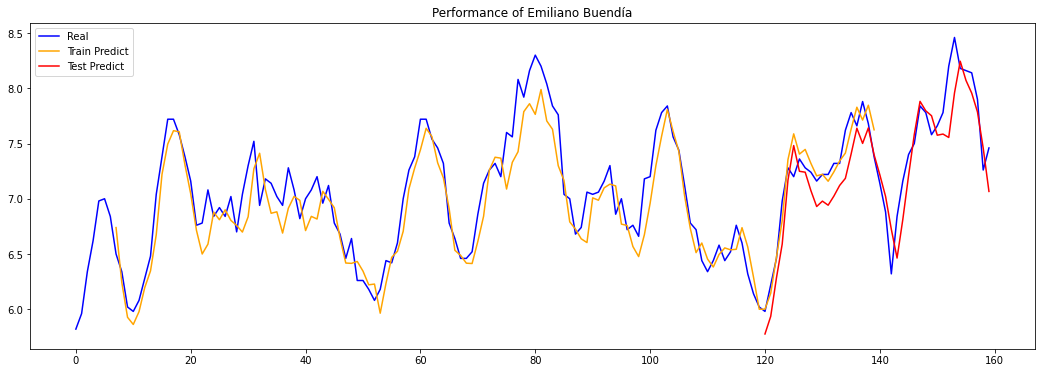

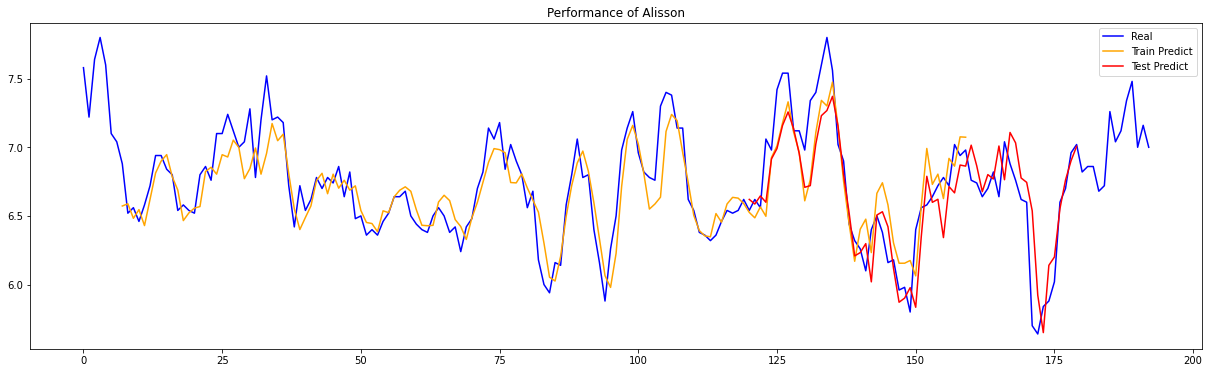

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_LSTM, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_LSTM.Filename,index=0)